# Housing price prediction

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data preperation

In [4]:
import pandas as pd
import numpy as np

In [448]:
cd_data = pd.read_csv('cd_raw.csv')

In [453]:
cd_data = cd_data.drop(cd_data[cd_data.unit_price == 'nan'].index)

In [454]:
cd_data.unit_price = cd_data.unit_price.apply(lambda x: str(x).split(':')[-1])

In [455]:
import matplotlib.pyplot as plt
import seaborn as sns

In [456]:
# change the format of unit_price 52,800 to 52800
cd_data.unit_price = cd_data.unit_price.apply(lambda x: int(x.replace(',','')))

In [457]:
# recalculate the total price by unit_price to get a more accurate amount, then adjusted to 10000 scale
cd_data['total_price'] = cd_data.unit_price*cd_data.house_size/10000

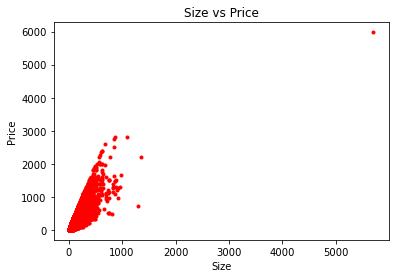

In [458]:
# quickly look at if there's outliers
plt.scatter(cd_data.house_size, cd_data.total_price, c = "red", marker = ".")
plt.title('Size vs Price')
plt.xlabel("Size")
plt.ylabel("Price")
plt.show()

In [459]:
# ignore the outlier
cd_data = cd_data[(cd_data.house_size < 1100) & (cd_data.total_price < 5000)]

<AxesSubplot:xlabel='total_price', ylabel='Count'>

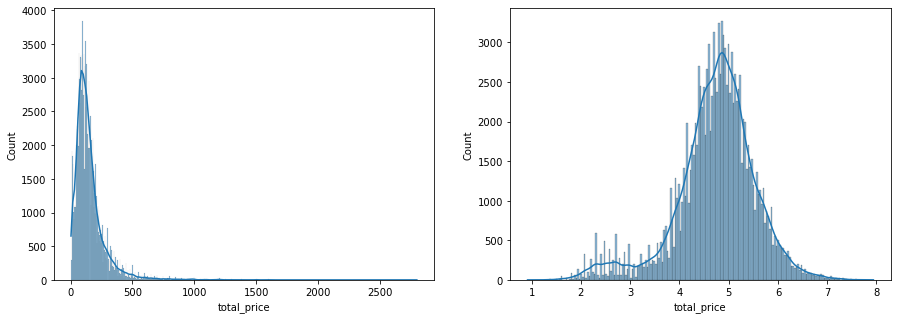

In [460]:
# plot the distribution of the prices, with normal scale and logrithmic scale 
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.histplot(cd_data['total_price'], ax = ax[0], kde=True)
sns.histplot(np.log(cd_data['total_price']), ax = ax[1], kde=True)

The distribution of total_price is clearly largely skrewed to the left. Adjusting to the logrithmic scale, it shows normal distribution. 

## Data cleaning 

In [19]:
df = cd_data.copy(deep = True)

In [20]:
df.head(2)

,area,title,community,position,unit_price,tax,star,release_time,subway,vr,has_key,house_type,house_size,direction,fitment,floor,year_built,structure_type,other_feature,total_price
0,海洋公园,万科海悦汇城东区 3室1厅 东南,万科海悦汇城东区,海洋公园,21302,房本满五年,7,28天,NaN,NaN,随时看房,3室1厅,105.32,东南,精装,高楼层(共50层),2014年建,塔楼,NaN,224.352664
1,海洋公园,恒大名都 3室1厅 东南,恒大名都,海洋公园,19095,NaN,48,7个月,NaN,NaN,随时看房,3室1厅,86.72,东南,精装,高楼层(共32层),2012年建,塔楼,NaN,165.591840


In [21]:
df = df.drop(columns = ['position','title'])
df = df.drop_duplicates()

In [22]:
# move false aligned data

for i in ['板塔结合','平房','塔楼','板楼']:
    df_slice = df.loc[df.year_built == i].copy()
    df_slice['other_feature'] =  df_slice['structure_type']
    df_slice['structure_type'] = df_slice['year_built']
    df_slice['year_built'] = np.nan
    
    df.loc[df.year_built == i] = df_slice
    
df_slice2 = df.loc[df.structure_type == '独栋别墅'].copy()
df_slice2['other_feature'] =  df_slice2['structure_type']
df_slice2['structure_type'] = np.nan
df.loc[df.structure_type == '独栋别墅'] = df_slice2

#df.iloc[12352,-3] = np.nan

Transform `tax` row to 1 and 0

In [23]:
df.tax = df.tax.apply(lambda x: 0 if x == '房本满五年' else 1)

Extract only time information from `release_time`

In [24]:
month = ['10个月','3个月', '9个月', '5个月','2个月', '1个月', '6个月', '4个月', '8个月', '7个月', '11个月']
index = df.release_time.apply(lambda x: True if x in month else False)

In [25]:
df.release_time = df.release_time.apply(lambda x: (str(x).split('天')[0].split('个')[0]))
df.release_time.loc[index] = df[index].release_time.apply(lambda x: int(x))*30

df.release_time[df.release_time == 'nan']= 360

Transform T/F variable to 1 and 0

In [26]:
df.subway[df.subway.isnull()] = 0
df.subway[df.subway == '近地铁'] = 1

df.vr[df.vr.isnull()] = 0
df.vr[df.vr == 'VR房源'] = 1

df.has_key[df.has_key.isnull()] = 0
df.has_key[df.has_key == '随时看房'] = 1


Split `house_type` to get the number of bedrooms and sitting rooms separately

In [27]:
# first get rid of those that are not "house"
df = df[df.house_type!='车位']

In [28]:
df['bedroom'] = df.house_type.apply(lambda x: (str(x).split('厅')[0].split('室')[0]))
df['sitting_room'] = df.house_type.apply(lambda x: (str(x).split('厅')[0].split('室')[1]))
df['bedroom'] = df['bedroom'].apply(lambda x: int(x))
df['sitting_room'] = df['sitting_room'].apply(lambda x: int(x))
df['total_rooms'] = df['bedroom'] + df['sitting_room']

df.drop('house_type', axis = 1, inplace = True)

Clean the `direction` variable 

In [29]:
df['num_directions'] = df.direction.apply(lambda x: len(x.split(' ')))

In [30]:
df['direction_south'] = 0
df['direction_north'] = 0
df['direction_east'] = 0
df['direction_west'] = 0
south_index = df.direction.apply(lambda x: True if '南' in x else False)
north_index = df.direction.apply(lambda x: True if '北' in x else False)
east_index = df.direction.apply(lambda x: True if '东' in x else False)
west_index = df.direction.apply(lambda x: True if '西' in x else False)

In [31]:
df['direction_north'][north_index] = 1
df['direction_south'][south_index] = 1
df['direction_east'][east_index] = 1
df['direction_west'][west_index] = 1
df.drop('direction', axis = 1, inplace = True)

Transform `fitment` to numeric variable

In [32]:
df.fitment = df.fitment.map({'精装':4,'简装':3,'其他':2, '毛坯':1})

Clean `yeat_built` column

In [33]:
df.year_built[df.year_built.isnull()] = 0
df.year_built[df.year_built=='暂无数据'] = 0
df.year_built = df.year_built.apply(lambda x: x.split('年')[0] if x != 0 else 0)
df.year_built = df.year_built.apply(lambda x: int(x))

In [34]:
df['house_age'] = 2022 - df.year_built
df['house_age'][df['house_age'] == 2022] = 0

Transform the `other_feature` and `structure_type` column accordingly to numeric variables

In [35]:
df.structure_type[df.structure_type == '暂无数据'] = np.nan

struc_df = pd.get_dummies(df.structure_type).rename(columns = {'塔楼':'struc_Type1','平房':'struc_Type2',
                                                    '板塔结合':'struc_Type3','板楼':'struc_Type4'})

df['struc_Type1'] = struc_df['struc_Type1']
df['struc_Type2'] = struc_df['struc_Type2']
df['struc_Type3'] = struc_df['struc_Type3']
df['struc_Type4'] = struc_df['struc_Type4']

df.drop('structure_type', axis = 1, inplace = True)

In [36]:
df.other_feature.fillna(0, inplace = True)
df.other_feature = df.other_feature.map({'独栋别墅':4,'双拼别墅':3, '联排别墅':2,'叠拼别墅':1,0:0})

Clean `floor` variable

In [37]:
df.floor = df.floor.apply(lambda x: x.split('(')[0].split('层')[0])

In [38]:
# ignore the houses with size > 200 which are labeled as underground house 
df[(df.floor == '地下室')][df[(df.floor == '地下室')]['house_size']>200]['floor'] = '上叠'

In [39]:
apartment_floor = ['3', '9', '1', '4', '7', '2', '5',
       '33', '32', '11', '31', '43', '36', '25', '29', '22', '26', '24',
       '18', '30', '27', '6', '17', '10', '12', '14', '13', '34',
       '16', '28', '23', '21', '51', '19', '20', '40', '39', '8', '15',
       '35']

In [40]:
L = []

for i in apartment_floor:
    L.append(int(i))
L.sort()
L2 = []
for i in L:
    L2.append(str(i))
apartment_floor_low = L2[0:14]
apartment_floor_medium = L2[14:28]
apartment_floor_high = L2[28:]

In [41]:
underground  = ['地下室']
low = ['低楼'] + apartment_floor_low
medium = ['中楼'] + apartment_floor_medium
high  = ['高楼'] + apartment_floor_high
special = ['下叠','上叠']

In [42]:
df.floor = df.floor.apply(lambda x: 0 if x in underground else x)
df.floor = df.floor.apply(lambda x: 1 if x in low else x)
df.floor = df.floor.apply(lambda x: 2 if x in medium else x)
df.floor = df.floor.apply(lambda x: 3 if x in high else x)
df.floor = df.floor.apply(lambda x: 4 if x in special else x)

Change Chinese character to English version, and create `district` and `inner` row to indicate which of the total 14 districts the house belongs and whether it locates in the inner 6 districts of Chengdu

In [43]:
jinjiang = {'川师':'chuanshi','大面':'damian','东大路':'dongdalu','东光小区':'dongguangxiaoqu','东湖':'donghu',
'东客站':'dongkezhan','合江亭':'hejiangting','红星路':'hongxinglu','静居寺':'jingjusi','九眼桥':'jiuyanqiao',
'蓝谷地':'langudi','莲花':'lianhua2','琉璃场':'liulichang','攀成钢':'panchenggang','三官堂':'sanguantang',
'三圣乡':'sanshengxiang','沙河堡':'shahebao','水碾河':'shuinianhe','盐市口':'yanshikou','卓锦城':'zhuojincheng'}

qingyang = {'八宝街':'babaojie','贝森':'beisen','草市街':'caoshijie','草堂':'caotang','府南新区':'funanxinqu',
'光华泡小':'guanghuapaoxiao','浣花溪':'huanhuaxi','金沙':'jinsha','宽窄巷子':'kuanzhaixiangzi','人民公园':'renmingongyuan',
'蜀汉路':'shuhanlu','太升路':'taishenglu','外光华':'waiguanghua','外金沙':'waijinsha','万家湾':'wanjiawan',
'西南财大':'xinancaida','盐市口':'yanshikou','优品道':'youpindao'}

wuhou = {'草金立交':'caojinlijiao','川大':'chuanda','川音':'chuanyin','簇桥':'cuqiao','高升桥':'gaoshengqiao',
'广福桥':'guangfuqiao','航空路':'hangkonglu','红牌楼':'hongpailou','华西':'huaxi','火车南站':'huochenanzhan',
'丽都':'lidu','龙湾':'longwan','双楠':'shuangnan','桐梓林':'tongzilin','外双楠':'waishuangnan','五大花园':'wudahuayuan',
'武侯祠':'wuhouci','武侯立交':'wuhoulijiao','新双楠':'xinshuangnan','玉林':'yulin','棕北':'zongbei'}

gaoxin = {'城南宜家':'chengnanyijia','大源':'dayuan','东苑':'dongyuan2','芳草':'fangcao','高朋':'gaopeng','广都':'guangdou',
'华府':'huafu1','华阳':'huayang','金融城':'jinrongcheng','丽都':'lidu','神仙树':'shenxianshu','市一医院':'shiyiyiyuan',
'天府长城':'tianfuchangcheng','新北':'xinbei','新会展':'xinhuizhan','新双楠':'xinshuangnan','衣冠庙':'yiguanmiao',
'远大':'yuanda','中德':'zhongde','中和':'zhonghe','紫荆':'zijing'}

chenghua = {'八里小区':'balixiaoqu','成渝立交':'chengyulijiao','东郊记忆':'dongjiaojiyi','东客站':'dongkezhan','动物园':'dongwuyuan',
'建设路':'jianshelu','理工大':'ligongda','李家沱':'lijiatuo','龙潭寺':'longtansi','猛追湾':'mengzhuiwan','沙河堡':'shahebao',
'驷马桥':'simaqiao','SM广场':'smguangchang','万年场':'wannianchang','万象城':'wanxiangcheng1','新华公园':'xinhuagongyuan'}

jinniu = {'八宝街':'babaojie','茶店子':'chadianzi','抚琴小区':'fuqinxiaoqu','高家庄':'gaojiazhuang','国宾':'guobin',
'花牌坊':'huapaifang','华侨城':'huaqiaocheng3','花照壁':'huazhaobi','金府':'jinfu','金牛万达':'jinniuwanda',
'九里堤':'jiulidi','马鞍路':'maanlu','沙湾':'shawanhuizhan','石人小区':'shirenxiaoqu','蜀汉路':'shuhanlu','天回镇':'tianhuizhen',
'通惠门':'tonghuimen','五块石':'wukuaishi','西南交大':'xinanjiaoda','营门口':'yingmenkou','一品天下':'yipintianxia'}

tianfuxinqu = {'海洋公园':'haiyanggongyuan','华阳':'huayang','锦江生态带':'jinjiangshengtaidai','麓湖生态城':'luhushengtaicheng',
'麓山':'lushan','南湖':'nanhu','仁寿':'renshou1','四河':'sihe','新会展':'xinhuizhan','雅居乐':'yajule'}

gaoxinxi = {'高新西':'gaoxinxi','中海国际':'zhonghaiguoji'}

shuangliu = {'簇桥':'cuqiao','东升镇':'dongshengzhen','公兴':'gongxing','航空港':'hangkonggang','蛟龙港':'jiaolonggang',
'警院':'jingyuan','九龙湖':'jiulonghu1','牧马山':'mumashan','双流城区':'shuangliuchengqu','文星镇':'wenxingzhen',
'新津':'xinjin'}

wenjiang = {'芙蓉古城':'furonggucheng','光华大道沿线':'guanghuadadaoyanxian','国色天乡':'guosetianxiang','花都大道':'huadudadao',
'温江大学城':'wenjiangdaxuecheng','温江老城':'wenjianglaocheng','温江新城':'wenjiangxincheng','珠江新城':'zhujiangxincheng'}

pidu = {'成外':'chengwai','红光':'hongguang','郫县城区':'pixianchengqu','郫县万达':'pixianwanda','橡树湾':'xiangshuwan',
'犀浦':'xipu'}

longquanyi = {'东山':'dongshan','航天':'hangtian','洪河':'honghe','龙泉驿城区':'longquanyichengqu','十陵':'shiling2',
'西河':'xihe','阳光城':'yangguangcheng'}

xindu = {'保利公园':'baoligongyuan','大丰':'dafeng','毗河':'pihe','新都城区':'xinduchengqu'}

qingbaijiang = {'青白江':'qingbaijiang'}

inner_districts = [jinjiang, qingyang, wuhou, jinniu, gaoxin, chenghua]
outer_districts = [tianfuxinqu, gaoxinxi, shuangliu, wenjiang, pidu, longquanyi, xindu, qingbaijiang]

jinjiang_mapping = {i : 'jinjiang' for i in jinjiang.values()}
qingyang_mapping = {i : 'qingyang' for i in qingyang.values()}
wuhou_mapping = {i : 'wuhou' for i in wuhou.values()}
jinniu_mapping = {i : 'jinniu' for i in jinniu.values()}
gaoxin_mapping = {i : 'gaoxin' for i in gaoxin.values()}
chenghua_mapping = {i : 'chenghua' for i in chenghua.values()}
tianfuxinqu_mapping = {i : 'tianfuxinqu' for i in tianfuxinqu.values()}
gaoxinxi_mapping = {i : 'gaoxinxi' for i in gaoxinxi.values()}
shuangliu_mapping = {i : 'shuangliu' for i in shuangliu.values()}
wenjiang_mapping = {i : 'wenjiang' for i in wenjiang.values()}
pidu_mapping = {i : 'pidu' for i in pidu.values()}
longquanyi_mapping = {i : 'longquanyi' for i in longquanyi.values()}
xindu_mapping = {i : 'xindu' for i in xindu.values()}
qingbaijiang_mapping = {i : 'qingbaijiang' for i in qingbaijiang.values()}

mappings = [jinjiang_mapping,qingyang_mapping,wuhou_mapping,jinniu_mapping,gaoxin_mapping,
chenghua_mapping,tianfuxinqu_mapping,gaoxinxi_mapping,shuangliu_mapping,wenjiang_mapping,
pidu_mapping,longquanyi_mapping ,xindu_mapping ,qingbaijiang_mapping]

In [44]:
# create all the necessary mapping dictionaries
def Merge(dict1, dict2): 
    '''
    Takes in two dictionary and outputs a merged dictionary
    '''
    res = {**dict1, **dict2} 
    return res 

dict_inner = {} 
dict_outer = {}
dict_all   = {}
mapping_all= {}

for i in inner_districts:
    dict_inner = Merge(dict_inner, i)

for i in outer_districts:
    dict_outer = Merge(dict_outer, i)

for i in mappings:
    mapping_all = Merge(mapping_all, i)
    
dict_all = Merge(dict_inner, dict_outer)


In [45]:
# First change the Chinese character to English
df.area = df.area.map(dict_all)

In [46]:
df['inner'] = df.area.apply(lambda x: 1 if x in dict_inner.values() else 0)
df['district'] = df.area.map(mapping_all)

## Data Analysis

### Top communities

In [47]:
top10_communities = df.groupby('community')['unit_price'].mean()[df.groupby('community')['area'].count()>30].sort_values(ascending = False)[:10]

In [48]:
for i in range(10):
    name = top10_communities.index[i]
    price = top10_communities[i]
    print(f'Top{i+1} community: {name} ({df[df.community == name]["district"].iloc[0]} district)')
    print(f'¥{round(price,0)}/square meter')

Top1 community: 四海逸家二期 (jinjiang district)
¥38817.0/square meter
Top2 community: 四海逸家一期 (jinjiang district)
¥38789.0/square meter
Top3 community: 融创四海逸家 (jinjiang district)
¥38752.0/square meter
Top4 community: 中海城南华府 (gaoxin district)
¥38493.0/square meter
Top5 community: 南城都汇汇彩园 (gaoxin district)
¥36458.0/square meter
Top6 community: 恒大都汇华庭 (jinjiang district)
¥35405.0/square meter
Top7 community: 朗御 (jinjiang district)
¥34781.0/square meter
Top8 community: 美年广场美岸 (tianfuxinqu district)
¥34613.0/square meter
Top9 community: 仁和春天国际花园 (gaoxin district)
¥34390.0/square meter
Top10 community: 南城都汇汇尚园 (gaoxin district)
¥34291.0/square meter


- As we can see in the table, half of ten communities with top prices locate in Jinjiang district. Gaoxin has four, and Tianfuxinqu has one. This means top communities in Jinjiang and Gaoxin districts accounts for 9/10 of all top communities.

### Real estate supply distribution

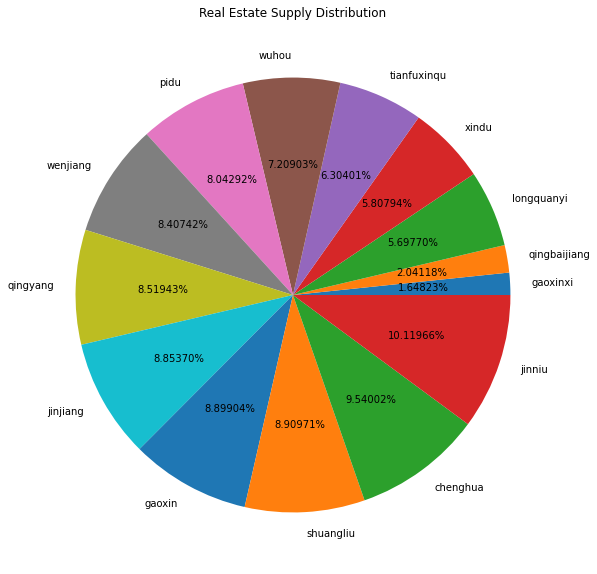

jinniu          11383
chenghua        10731
shuangliu       10022
gaoxin          10010
jinjiang         9959
qingyang         9583
wenjiang         9457
pidu             9047
wuhou            8109
tianfuxinqu      7091
xindu            6533
longquanyi       6409
qingbaijiang     2296
gaoxinxi         1854
Name: district, dtype: int64


In [49]:
fig,ax = plt.subplots(1, figsize = (10,10))
ax.pie(df.district.value_counts().sort_values()
        ,autopct="%1.5f%%"
        ,labels = df.district.value_counts().sort_values().index)

plt.title('Real Estate Supply Distribution')
plt.show()
print(df.district.value_counts().sort_values(ascending=False))
print('='*100)

- The supply of house does not differ significantly from place to place. The district with highest supply, Jinniu, takes only 10th of all percentages. But in general, the inner districts, the six districts that are closer to central business district(CBD) have more houses for sale. 

### Location and price level

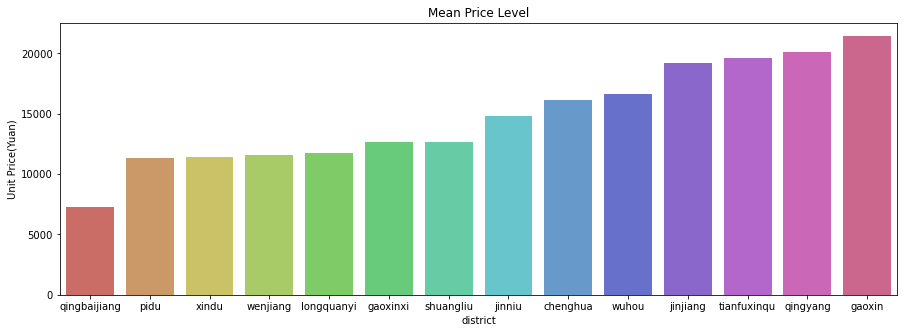

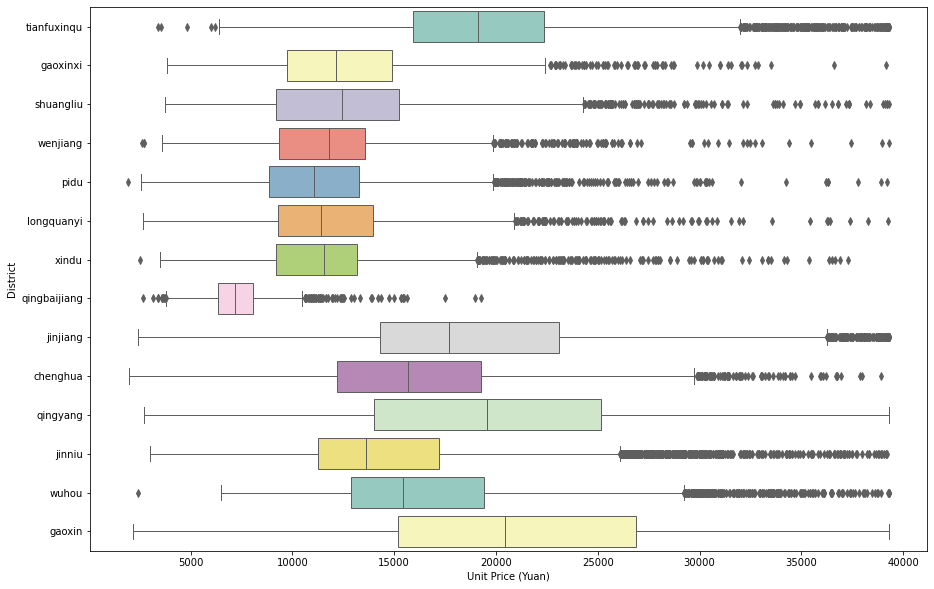

district
gaoxin          21450.0
qingyang        20082.0
tianfuxinqu     19582.0
jinjiang        19179.0
wuhou           16621.0
chenghua        16154.0
jinniu          14845.0
shuangliu       12660.0
gaoxinxi        12652.0
longquanyi      11784.0
wenjiang        11613.0
xindu           11413.0
pidu            11317.0
qingbaijiang     7262.0
Name: unit_price, dtype: float64 0


In [50]:
fig,ax = plt.subplots(1, figsize = (15,5))
sns.barplot(df.groupby('district')['unit_price'].mean().sort_values().index, 
            df.groupby('district')['unit_price'].mean().sort_values(),palette="hls")
plt.title('Mean Price Level')
plt.ylabel('Unit Price(Yuan)')
plt.xlabel('district')
plt.show()

fig,ax = plt.subplots(1, figsize = (15,10))
sns.boxplot(df['unit_price'],df['district'], palette="Set3", linewidth=1)
plt.ylabel('District')
plt.xlabel('Unit Price (Yuan)')
plt.show()

print(round(df.groupby('district')['unit_price'].mean().sort_values(ascending = False)),0)
print('='*100)

- The trend is intuitive and clear, the inner districts generally have higher median unit price than the outer regions, except for Tianfuxinqu. But considering the fact that Tianfuxinq is a high tech zone actively promoted by the government, the relatively high price is understandable. And from the box plot we can also observe that the places with higher mean unit price also tends to fluctuate more in their overall prices (the boxes tend to be longer).

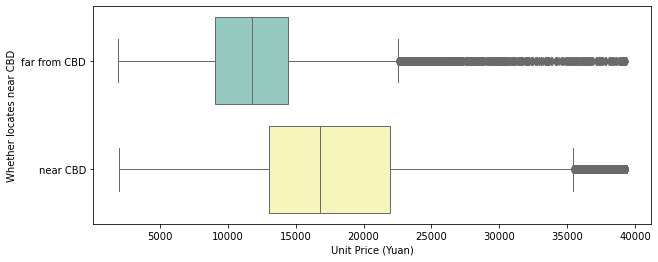

In [51]:
fig,ax = plt.subplots(1, figsize = (10,4))
sns.boxplot(df['unit_price'],df['inner'].apply(lambda x: 'near CBD' if x==1 else 'far from CBD')
            , palette="Set3", linewidth=1)
plt.ylabel('Whether locates near CBD')
plt.xlabel('Unit Price (Yuan)')
plt.show()

- The boxplot visualize the trend mentioned above: the houses in outer districts of Chengdu tend to have lower price than those that are closer to the city center, which is a commonsense 

### Exposure and price distribution

In [52]:
exposure = df[['total_price', 'star']]
exposure.star[df.star < 20] = 'low'
exposure.star[(df.star >= 20) & (df.star < 100)] = 'medium'
exposure.star[df.star >= 100] = 'high'

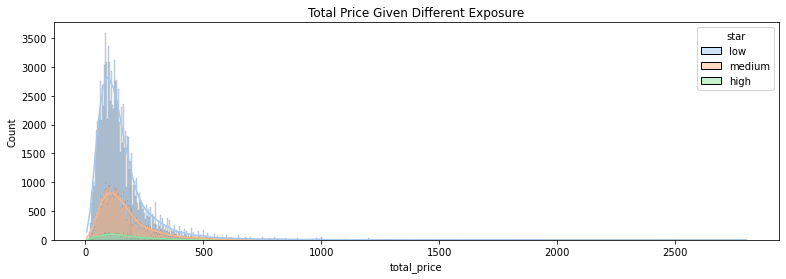

In [53]:
fig,ax = plt.subplots(1, figsize = (13,4))

sns.histplot(data=exposure, ax=ax, stat="count", multiple="stack",
             x='total_price', kde=True,
             palette="pastel", hue='star',
             element="bars", legend=True)
plt.title('Total Price Given Different Exposure')
plt.show()

- The price almost has same distribution considering different stars received. So this feature might not be important in determining the real estate price

### Influence of addional information

In [54]:
tags = df[['subway','vr','has_key','tax','total_price']]
tags['subway'] = tags['subway'].map({0:'Not close to subway',1:'Close to subway'})
tags['vr']     = tags['vr'].map({0:'Without VR option',1:'With VR option'})
tags['has_key']= tags['has_key'].map({0:'No key',1:'Has key'})
tags['tax']    = tags['tax'] .map({0:'No tax (deeds over 5yrs)',1:'Has tax'})

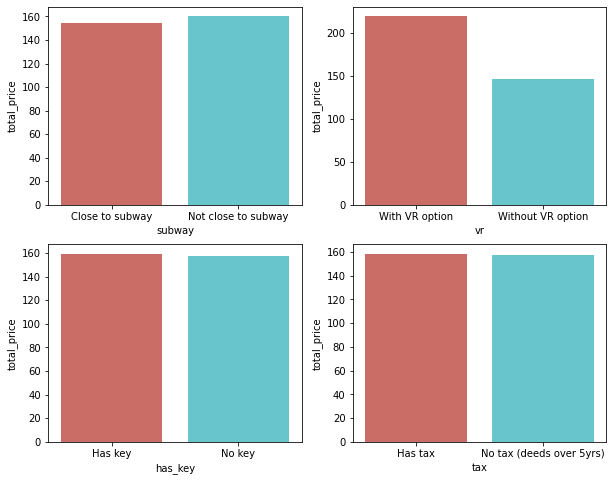

Mean Price:
vr
With VR option       218.716735
Without VR option    145.968044
Name: total_price, dtype: float64
***********************************
Counts:
Without VR option    93737
With VR option       18747
Name: vr, dtype: int64


In [55]:

fig,ax = plt.subplots(2,2, figsize = (10,8))
sns.barplot(tags.groupby('subway')['total_price'].mean().index
            ,tags.groupby('subway')['total_price'].mean(), palette="hls", linewidth=1, ax = ax[0,0])

sns.barplot(tags.groupby('vr')['total_price'].mean().index
            ,tags.groupby('vr')['total_price'].mean(), palette="hls", linewidth=1, ax = ax[0,1])

sns.barplot(tags.groupby('has_key')['total_price'].mean().index
            ,tags.groupby('has_key')['total_price'].mean(), palette="hls", linewidth=1, ax = ax[1,0])

sns.barplot(tags.groupby('tax')['total_price'].mean().index
            ,tags.groupby('tax')['total_price'].mean(), palette="hls", linewidth=1, ax = ax[1,1])
plt.show()
print('Mean Price:')
print(tags.groupby('vr')['total_price'].mean())
print('*'*35)
print('Counts:')
print(tags['vr'].value_counts())

- Only the VR option shows a visible difference in mean house price. Presumably, it is due to the fact that community with higher prices tend to use this technology to help sell houses. 

### Decoration level and price

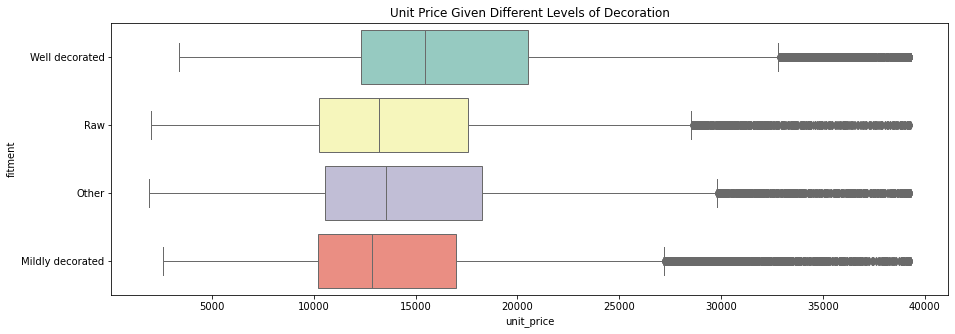

Unit Price:
            mean  count
fitment                
1        14763.0  12259
2        15144.0  17160
3        14193.0  38374
4        16960.0  44691 0
Total Price:
          mean  count
fitment              
1        210.0  12259
2        153.0  17160
3        127.0  38374
4        173.0  44691 0
Where {4: Well decorated, 3:Mildly decorated, 2:Other, 1: Raw}


In [56]:
fitment = df.fitment.map({4: 'Well decorated', 3:'Mildly decorated', 2:'Other', 1: 'Raw'})
fig,ax = plt.subplots(1, figsize = (15,5))
sns.boxplot(df['unit_price'],fitment, palette="Set3", linewidth=1)
plt.title('Unit Price Given Different Levels of Decoration')
plt.show()
print('Unit Price:')
print(round(df.groupby('fitment')['unit_price'].agg(['mean', 'count'])),0)
print('='*30)
print('Total Price:')
print(round(df.groupby('fitment')['total_price'].agg(['mean', 'count'])),0)
print('Where {4: Well decorated, 3:Mildly decorated, 2:Other, 1: Raw}')

- Suprisingly, most of the houses on sale are well decorated ones. It constitutes around 40% of the housing market. More importantly, the result shows that the decorated houses tend to have lower total values but higher unit price. It may due to insufficient data, but it can also be the result of the fact that decoration is a strategy used by small-house owners to improve the value of the house. 

### House age and price¶

In [57]:
age_df = df[df.house_age!=0][['house_age','unit_price']]

age_df['house_age'][df[df.house_age!=0].house_age<=10] = 'New'
age_df['house_age'][(df[df.house_age!=0].house_age>10)&(df[df.house_age!=0].house_age<=32)] = 'Medium'
age_df['house_age'][df[df.house_age!=0].house_age>32] = 'old'

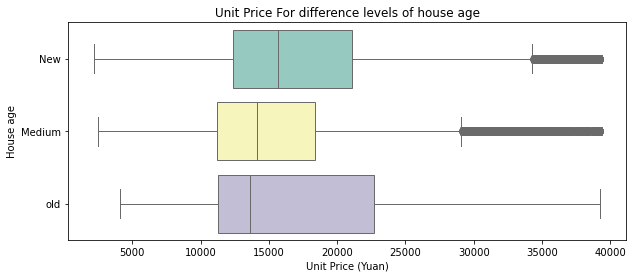

In [58]:
fig,ax = plt.subplots(1, figsize = (10,4))
sns.boxplot(age_df['unit_price'],age_df['house_age'], palette="Set3", linewidth=1)
plt.ylabel('House age')
plt.xlabel('Unit Price (Yuan)')
plt.title('Unit Price For difference levels of house age')
plt.show()


- From the box plot, the difference in median value is subtle 

### Unit price vs total rooms and floor

In [59]:
df.total_rooms = df.total_rooms.apply(lambda x: 10 if x>10 else x)

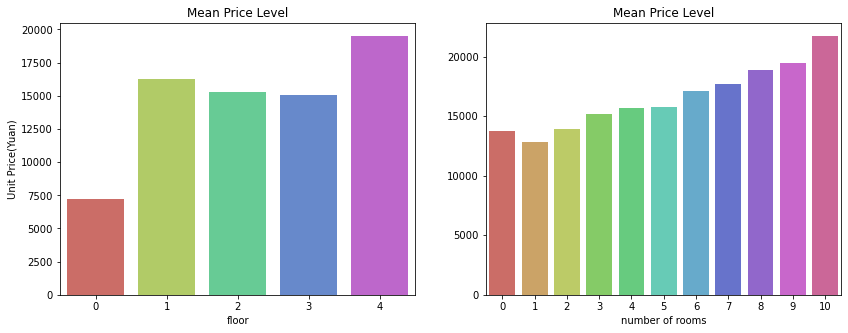

Number of rooms vs unit price:
total_rooms
1     12804.0
0     13745.0
2     13944.0
3     15177.0
4     15648.0
5     15804.0
6     17104.0
7     17728.0
8     18868.0
9     19486.0
10    21729.0
Name: unit_price, dtype: float64 2
Floor vs unit price:
floor
0     7233.0
3    15064.0
2    15254.0
1    16239.0
4    19513.0
Name: unit_price, dtype: float64 2
where underground:0，low:1，medium:2，high:3，villa:4


In [60]:
#Note: as for the second graph, all the total_rooms value with entries less than 100 are filterd
fig,ax = plt.subplots(1,2, figsize = (14,5))
sns.barplot(df.groupby('floor')['unit_price'].mean().sort_values().index, 
            df.groupby('floor')['unit_price'].mean().sort_values(),palette="hls",ax = ax[0])
ax[0].set(title = 'Mean Price Level',
         ylabel ='Unit Price(Yuan)',
         xlabel = 'floor')

sns.barplot(df.groupby('total_rooms')['unit_price'].mean().sort_values().index, 
            df.groupby('total_rooms')['unit_price'].mean().sort_values(),palette="hls",ax = ax[1])
ax[1].set(title = 'Mean Price Level',
          ylabel= '', 
         xlabel = 'number of rooms')
plt.show()

print('Number of rooms vs unit price:')
print(round(df.groupby('total_rooms')['unit_price'].mean().sort_values()),2)
print('='*30)
print('Floor vs unit price:')
print(round(df.groupby('floor')['unit_price'].mean().sort_values()),2)
print('where underground:0，low:1，medium:2，high:3，villa:4')

- Intuitively, undergroud rooms are cheaper than the normal houses. The first bar plot conforms with this intuition. In contrast, villa is a special type of `floor` with highest mean unit price. Rather than the height of the house above ground, this variable is more like a catagorical feature(similar to `other_feature` column) indicating a higher mean price in larger houses. As for the room numbers, there is an obvious increasing trend in unit price as number of rooms increases. Possibly the room numbers is just an indicator of the house size that correlates with the unit price. 

## Modeling

In [247]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

### Further transform the dataset 

In [179]:
X = df.copy(deep = True)
X = X.drop(columns = ['community','unit_price','total_price','year_built','star'
                      ,'release_time'])
y = np.log1p(df.total_price)
X = pd.get_dummies(X)
X['subway'] = X['subway_1']
X['has_key'] = X['has_key_1']
X['vr'] = X['vr_1']

X = X.drop(columns = ['has_key_0', 'subway_0', 'vr_0','has_key_1', 'subway_1', 'vr_1'])

### Train test split
- The dataset has over 110,000 lines of data, it is reasonable to choose a relatively small test size percentage
- Note: the output R^2 of testing set will `not` be used for evaluation. The spliting of train and test set is solely used for the visualization of the performance of different models.

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

### Robust scaling 
- to lower the influence of outliers and speed up model fitting

In [181]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()
X_train = RS.fit_transform(X_train)
X_test = RS.transform(X_test)
X_total = RS.fit_transform(X)

### Evaluating metric: RMSLE
- Results are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [432]:
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=15, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# def cv_rmse(model, X = X, y = y):
#     rmse = np.sqrt(-cross_val_score(model, X, y,
#                                     scoring="neg_mean_squared_error", cv=kf))
#     return (rmse)


### Linear models

#### Unregulated linear regression 

In [528]:
def prediction_plot(y_train_pred, y_test_pred, y_train, y_test): 
    plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data", s = 1)
    plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Testing data", s = 1)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.show()

def evaluate(model):
    model.fit(X_train, y_train)
    # Look at predictions on training and validation set
    print("RMSE of training set: ", round(rmsle(y_train, model.predict(X_train)),4))
    print("RMSE of testing  set: ", round(rmsle(y_test, model.predict(X_test)),4))
    
    print("R square of training set: ", round(model.score(X_train, y_train),4))
    print("R square of testing  set: ", round(model.score(X_test, y_test),4))
    prediction_plot(model.predict(X_train), model.predict(X_test), y_train, y_test)

RMSE of training set:  0.2903
RMSE of testing  set:  0.2903
R square of training set:  0.7957
R square of testing  set:  0.7983


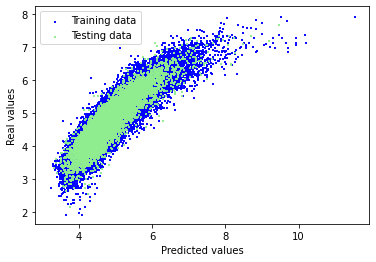

In [67]:
# Linear Regression
lr = LinearRegression()
evaluate(lr)

#### Regulated linear regression 

Best alpha : 0.3
RMSE of training set:  0.2903
RMSE of testing  set:  0.2903
R square of training set:  0.7957
R square of testing  set:  0.7983


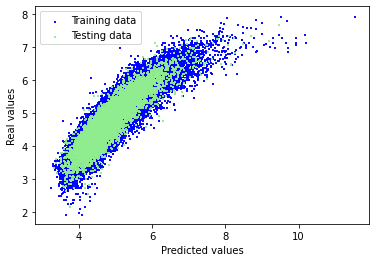

In [68]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)
evaluate(ridge)


- No improvement, so linear models will be abandoned 

#### Neural Network

In [500]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.1))

model.add(Dense(1))

In [504]:
model.compile(optimizer='Adam', loss='mean_squared_error')

record = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1000,
              epochs=100
             )


Epoch 1/100
102/102 [==============================] - 4s 33ms/step - loss: 0.0562 - val_loss: 0.0353
Epoch 2/100
102/102 [==============================] - 3s 31ms/step - loss: 0.0301 - val_loss: 0.0347
Epoch 3/100
102/102 [==============================] - 3s 34ms/step - loss: 0.0291 - val_loss: 0.0351
Epoch 4/100
102/102 [==============================] - 4s 35ms/step - loss: 0.0284 - val_loss: 0.0357
Epoch 5/100
102/102 [==============================] - 4s 35ms/step - loss: 0.0281 - val_loss: 0.0344
Epoch 6/100
102/102 [==============================] - 4s 39ms/step - loss: 0.0274 - val_loss: 0.0338
Epoch 7/100
102/102 [==============================] - 4s 37ms/step - loss: 0.0271 - val_loss: 0.0346
Epoch 8/100
102/102 [==============================] - 3s 33ms/step - loss: 0.0269 - val_loss: 0.0344
Epoch 9/100
102/102 [==============================] - 4s 34ms/step - loss: 0.0261 - val_loss: 0.0344
Epoch 10/100
102/102 [==============================] - 4s 36ms/step - loss: 0.026

In [543]:
# the error on training set remains high even though the model is complicated enough
print(np.sqrt(0.0152),np.sqrt(0.0370))

0.12328828005937953 0.19235384061671346


#### Random Forest

RMSE of training set:  0.061
RMSE of testing  set:  0.1649
R square of training set:  0.991
R square of testing  set:  0.9349


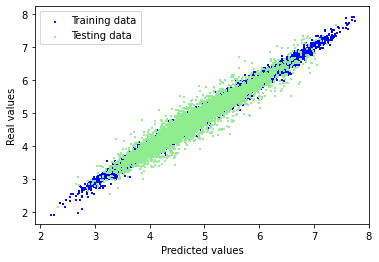

In [69]:
rf = RandomForestRegressor(random_state=42)
evaluate(rf)

Training set Best score: 0.061
Training set Complexity: 50
Testing  set Best score: 0.1649
Tesing set Complexity: 50


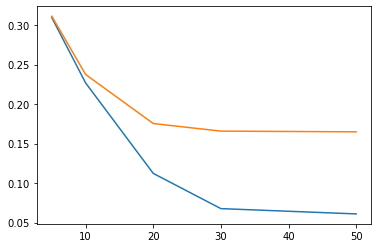

In [160]:
supera_train=[]
supera_test =[]
range_ = [5,10,20,30,50]
for i in range_:
    rfc=RandomForestRegressor(random_state=42
                              ,n_estimators=1000
                              ,max_depth = i)
    rfc.fit(X_train,y_train)
    score_train = round(rmsle(y_train, rfc.predict(X_train)),4)
    score_test  = round(rmsle(y_test, rfc.predict(X_test)),4)
    supera_train.append(score_train)
    supera_test.append(score_test)
    
print('Training set Best score:',min(supera_train))
print('Training set Complexity:',range_[supera_train.index(min(supera_train))])
print('Testing  set Best score:',min(supera_test))
print('Tesing set Complexity:',range_[supera_test.index(min(supera_test))])
plt.plot(range_,supera_train)
plt.plot(range_,supera_test)

RMSE of training set:  0.061
RMSE of testing  set:  0.1649
R square of training set:  0.991
R square of testing  set:  0.9349


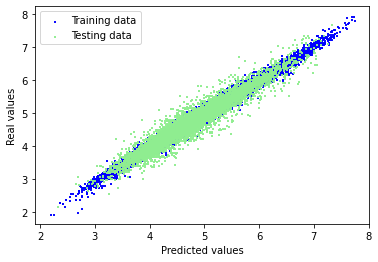

In [88]:
rf = RandomForestRegressor(random_state=42, max_depth = 50)
evaluate(rf)

The overall performance of random forest is similar for max_depth = 50 and the default greedy strategy, but it performs significantly less well when the model is not complex. Therefore, we will just choose max_depth = 50. Observing the difference between training and testing set, the training set seems to be overfitted. So the next step is to regulate the model.

In [124]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':[50]
             ,'min_samples_split':np.arange(2, 23, 5)
             ,'min_samples_leaf':np.arange(1, 23, 5)} 
GS=GridSearchCV(rf,param_grid,cv=10, scoring = 'neg_mean_squared_error')
GS.fit(X_train,y_train)
print(GS.best_params_, np.sqrt(abs(GS.best_score_)))

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.16480265533317995


{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.165

The result shows the random forest does not overfit. Changing the default strategy actually further lower the performance. Therefore, we will just stick to the original model, without further fine tuning.  

### XGBoost

RMSE of training set:  0.1753
RMSE of testing  set:  0.1873
R square of training set:  0.9255
R square of testing  set:  0.9161


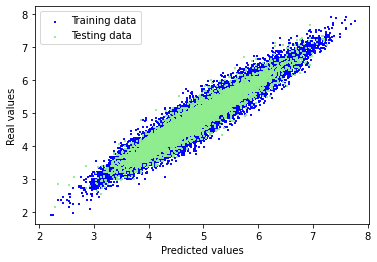

In [79]:
from xgboost import XGBRegressor
xgboost = XGBRegressor(random_state=42)
evaluate(xgboost)

With the default setting, the training set score is not high as above. So we may first try a more complicated model to overfit and then regulate.

RMSE of training set:  0.0482
RMSE of testing  set:  0.1619
R square of training set:  0.9944
R square of testing  set:  0.9373


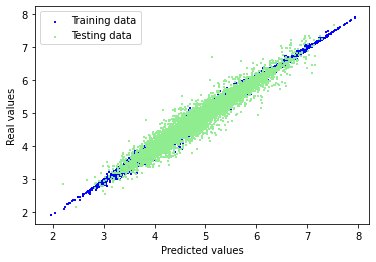

In [81]:
xgboost = XGBRegressor(random_state=42, max_depth = 20)
evaluate(xgboost)

Clearly max_depth = 20 somehow overfit the dataset, therefore we can try lowering this parameter. 
The default max_depth is 6, and so far 18 has the best performance. It is therefore resonable to further search between these two numbers. After ploting the learning curve and some trials, the best parameter is 18.

RMSE of training set:  0.0614
RMSE of testing  set:  0.1606
R square of training set:  0.9908
R square of testing  set:  0.9383


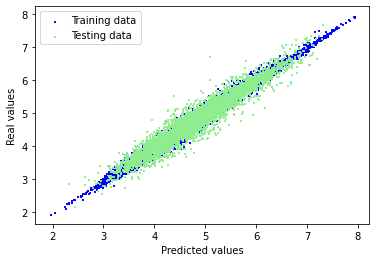

In [82]:
xgboost = XGBRegressor(random_state=42, max_depth = 18)
evaluate(xgboost)

RMSE: 0.1604 Gamma: 0.01


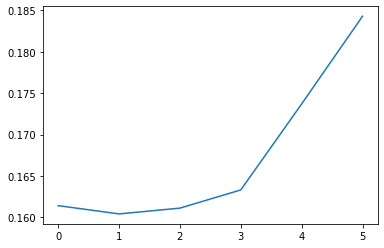

In [298]:
gamma_list = []
supera_test = []
for i in [0.001,0.01,0.05,0.1,0.5,1]:
    xgboost = XGBRegressor(random_state = 42, max_depth = 18
                       ,gamma = i)
    xgboost.fit(X_train,y_train)
    score_train = round(rmsle(y_train, xgboost.predict(X_train)),4)
    score_test  = round(rmsle(y_test, xgboost.predict(X_test)),4)

    gamma_list.append(i)
    supera_test.append(score_test)

print("RMSE:",min(supera_test), "Gamma:",gamma_list[supera_test.index(min(supera_test))])
plt.plot(supera_test)
plt.show()

RMSE: 0.1593 Gamma: 0.007


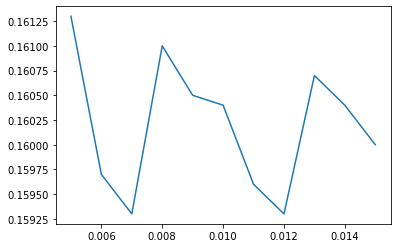

In [301]:
gamma_list = []
supera_test = []
for i in np.arange(0.005,0.016,0.001):
    xgboost = XGBRegressor(random_state = 42, max_depth = 18
                       ,gamma = i)
    xgboost.fit(X_train,y_train)
    score_train = round(rmsle(y_train, xgboost.predict(X_train)),4)
    score_test  = round(rmsle(y_test, xgboost.predict(X_test)),4)

    gamma_list.append(i)
    supera_test.append(score_test)

print("RMSE:",min(supera_test), "Gamma:",gamma_list[supera_test.index(min(supera_test))])
plt.plot(np.arange(0.005,0.016,0.001), supera_test)
plt.show()

RMSE of training set:  0.0628
RMSE of testing  set:  0.1593
R square of training set:  0.9904
R square of testing  set:  0.9393


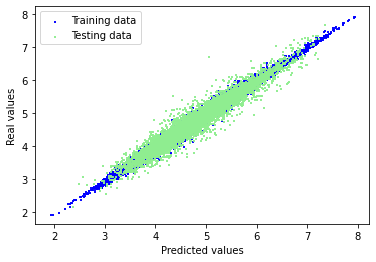

In [302]:
xgboost = XGBRegressor(random_state=42, max_depth = 18, gamma = 0.007)
evaluate(xgboost)

#### Lightgbm

RMSE of training set:  0.0932
RMSE of testing  set:  0.1598
R square of training set:  0.9789
R square of testing  set:  0.9389


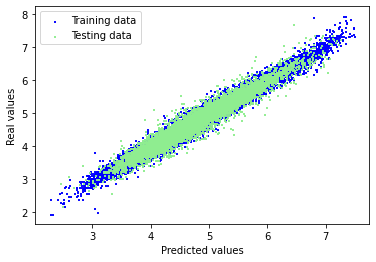

In [201]:
lightgbm = LGBMRegressor(random_state=42
                         ,learning_rate = 0.1
                         ,num_leaves=2000
                         #,max_depth = 100
                         ,colsample_bytree = 0.7
                         ,reg_lambda = 0.2
                         #,reg_alpha = 0.2
                         )
evaluate(lightgbm)

In [237]:
supera_train=[]
supera_test =[]
history_index = []
for a in np.arange(0.65,0.75,0.01):
    for b in [0,0.01,0.1,0.3,1]:
        lightgbm = LGBMRegressor(random_state=42
                             ,learning_rate = 0.1
                             ,num_leaves=2000
                             #,max_depth = 100
                             ,colsample_bytree = a
                             ,reg_lambda = b
                             #,reg_alpha = 0.2
                             )
        lightgbm.fit(X_train,y_train)
        score_train = round(rmsle(y_train, lightgbm.predict(X_train)),4)
        score_test  = round(rmsle(y_test, lightgbm.predict(X_test)),4)
        history_index.append((round(a,4),round(b,4)))
        supera_train.append(score_train)
        supera_test.append(score_test)


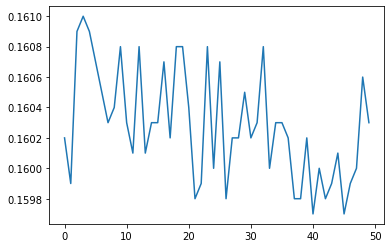

In [242]:
plt.plot(supera_test)
plt.show()

In [240]:
history_index[supera_test.index(min(supera_test))]

(0.73, 0)

RMSE of training set:  0.0896
RMSE of testing  set:  0.1597
R square of training set:  0.9805
R square of testing  set:  0.939


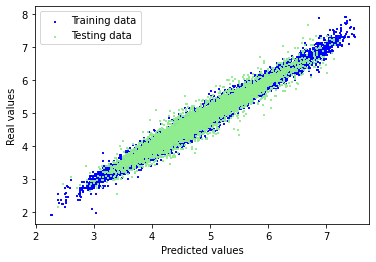

In [241]:
lightgbm = LGBMRegressor(random_state=42
                         ,learning_rate = 0.1
                         ,num_leaves=2000
                         ,colsample_bytree = 0.73
                         ,reg_lambda = 0.0
                         )
evaluate(lightgbm)

#### Gradient Boosting Regressor

RMSE of training set:  0.2422
RMSE of testing  set:  0.2453
R square of training set:  0.8578
R square of testing  set:  0.8561


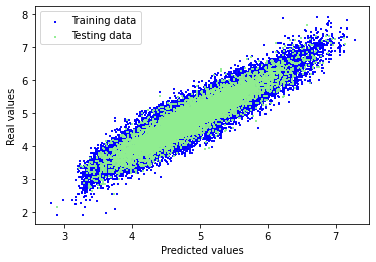

In [275]:
gbr = GradientBoostingRegressor(random_state=42)  
evaluate(gbr)

After tuning:

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3404           0.0702            1.92m
         2           0.2850           0.0561            1.93m
         3           0.2386           0.0457            1.88m
         4           0.2008           0.0370            1.88m
         5           0.1687           0.0304            1.86m
         6           0.1439           0.0246            1.86m
         7           0.1229           0.0202            1.86m
         8           0.1058           0.0164            1.84m
         9           0.0922           0.0132            1.82m
        10           0.0797           0.0109            1.80m
        20           0.0316           0.0016            1.68m
        30           0.0208           0.0002            1.65m
        40           0.0165           0.0000            1.74m
        50           0.0143           0.0000            1.74m
        60           0.0130          -0.0000            1.60m
       

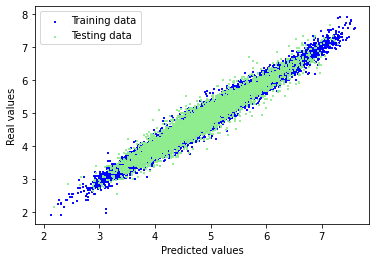

In [266]:
gbr = GradientBoostingRegressor(max_depth=50
                                ,min_samples_leaf=20
                                ,random_state=42
                                ,subsample=0.7
                                ,verbose=1)

evaluate(gbr)

### Stacking

In [309]:
lightgbm = LGBMRegressor(random_state=42
                         ,learning_rate = 0.1
                         ,num_leaves=2000
                         ,colsample_bytree = 0.73
                         ,reg_lambda = 0.0
                         )

rf = RandomForestRegressor(random_state=42, max_depth = 50)

gbr = GradientBoostingRegressor(max_depth=50, min_samples_leaf=20, random_state=42,
                          subsample=0.7)

xgboost = XGBRegressor(random_state=42, max_depth = 18, gamma = 0.007)


# Stack up all the models above, optimized using xgboost
stack = StackingCVRegressor(regressors=(xgboost, lightgbm, gbr, rf),
                                meta_regressor=xgboost,
                                )


RMSE of training set:  0.076
RMSE of testing  set:  0.1604
R square of training set:  0.986
R square of testing  set:  0.9385


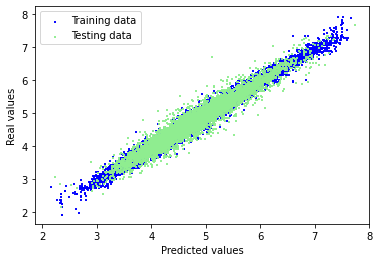

In [310]:
evaluate(stack)

### Averaging

In [325]:
lightgbm.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.73, num_leaves=2000, random_state=42)

In [326]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, random_state=42)

In [327]:
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.007, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=18,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [328]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=50, min_samples_leaf=20, random_state=42,
                          subsample=0.7)

In [434]:
rmsle_list = []
proportion = []

for i in np.arange(0.3,0.81,0.05):
    for j in np.arange(0,0.11,0.01):
        def blended_predictions(X):
            return ((i * lightgbm.predict(X))  + (j * rf.predict(X))+ ((0.1-j) * gbr.predict(X))+\
                     0.1*stack.predict(X)+\
                    ((0.8-i) * xgboost.predict(X)))
        score = rmsle(y_test,blended_predictions(X_test))
        rmsle_list.append(score)
        proportion.append((i ,j))

In [440]:
print("Min RMSLE:",round(min(rmsle_list),4), "Index: ", proportion[rmsle_list.index(min(rmsle_list))])

Min RMSLE: 0.1529 Index:  (0.39999999999999997, 0.1)


In [438]:
def blended_predictions(X):
    return ((0.4 * lightgbm.predict(X))  + (0.1 * rf.predict(X))+ (0.0 * gbr.predict(X))+\
            0.1*stack.predict(X)+\
            (0.4 * xgboost.predict(X)))
rmsle(y_test,blended_predictions(X_test))

0.15288251319842042

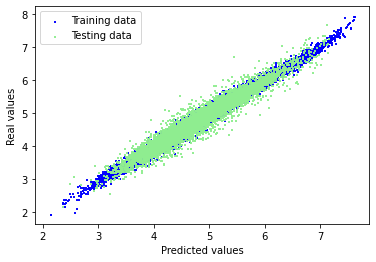

In [529]:
prediction_plot(blended_predictions(X_train),blended_predictions(X_test),y_train,y_test)

In [531]:
rmsle(y_train,blended_predictions(X_train))

0.06914221861889813

## Predicting

In [ ]:
def predict_price(scaler, model, df):
    return np.expm1(model.predict(RS.transform(df)))

def blended_predict(scaler, df):
    return np.expm1(blended_predictions(RS.transform(df)))

In [103]:
def collect_info(df):
    info = pd.DataFrame(data = {i:0 for i in X.columns},index = [0])
    
    print('Deeds over 5 years(房本满五年 1 for Yes/ 0 for No)? ：')
    info['tax'] = int(input())
    print('House size(面积)/square meter？：')
    info['house_size'] = float(input())
    print("Fitment(精装:4, 简装:3, 其他:2, 毛坯:1)？：")
    info['fitment'] = int(input())
    print('Floor(楼层 地下室:0，低楼层:1，中楼层:2，高楼层:3，上叠/下叠（别墅）:4)？：')
    info['floor'] = int(input())
    print('House type(独栋别墅:4, 双拼别墅:3, 联排别墅:2, 叠拼别墅:1, 非别墅:0)？：')
    info['other_feature'] = int(input())
    print('How many bedrooms(几室)？：')
    info['bedroom'] = int(input())
    print('How many sitting rooms(几厅)？：')
    info['sitting_room'] = int(input())
    info['total_rooms'] = info['sitting_room']+info['bedroom'] 
    print('Face south（朝南 1 for Yes/ 0 for No）？：')
    info['direction_south']= int(input())
    print('Face north（朝北 1 for Yes/ 0 for No）？：')
    info['direction_north']= int(input())
    print('Face west（朝西 1 for Yes/ 0 for No）？：')
    info['direction_west']= int(input())
    print('Face east（朝东 1 for Yes/ 0 for No）？：')
    info['direction_east']= int(input())
    info['num_directions'] = info['direction_south']+info['direction_north']+info['direction_west']+info['direction_east']
    print('House age（房龄 0 if unknown）？：')
    info['house_age']= int(input())
    print('House structure type（建筑结构 塔楼:1, 平房:2, 板塔结合:3, 板楼:4）？：')
    x = input()
    info['struc_Type'+x] = 1
    print('District（哪个区 e.x. jinjiang, gaoxin）？：')
    x = input()
    info['district_'+x] = 1
    if x in ['jinjiang', 'chenghua','qingyang', 'jinniu', 'wuhou', 'gaoxin']:
        info['inner'] = 1
    print('Area（具体商业地区 enter -1 to see the whole list）？：')
    x = input()
    if x == '-1':
        for i in X.columns[19:175]:
            print(i)
        print('Try again: ')
        info['area_'+input()] = 1
    else: info['area_'+x] = 1
    
    print('Close to subway（近地铁 1 for Yes/ 0 for No）？：')
    info['subway'] = int(input())
    print('Provide VR（提供VR 1 for Yes/ 0 for No）？：')
    info['vr'] = int(input())
    print('Has Key（有钥匙 1 for Yes/ 0 for No）？：')
    info['has_key'] = int(input())
    
    return info

In [104]:
my_home = collect_info(X)

Deeds over 5 years(房本满五年 1 for Yes/ 0 for No)? ：
1
House size(面积)/square meter？：
300
Fitment(精装:4, 简装:3, 其他:2, 毛坯:1)？：
4
Floor(楼层 地下室:0，低楼层:1，中楼层:2，高楼层:3，上叠/下叠（别墅）:4)？：
4
House type(独栋别墅:4, 双拼别墅:3, 联排别墅:2, 叠拼别墅:1, 非别墅:0)？：
2
How many bedrooms(几室)？：
4
How many sitting rooms(几厅)？：
2
Face south（朝南 1 for Yes/ 0 for No）？：
1
Face north（朝北 1 for Yes/ 0 for No）？：
1
Face west（朝西 1 for Yes/ 0 for No）？：
0
Face east（朝东 1 for Yes/ 0 for No）？：
0
House age（房龄 0 if unknown）？：
12
House structure type（建筑结构 塔楼:1, 平房:2, 板塔结合:3, 板楼:4）？：
3
District（哪个区 e.x. jinjiang, gaoxin）？：
tianfuxinqu
Area（具体商业地区 enter -1 to see the whole list）？：
huayang
Close to subway（近地铁 1 for Yes/ 0 for No）？：
0
Provide VR（提供VR 1 for Yes/ 0 for No）？：
1
Has Key（有钥匙 1 for Yes/ 0 for No）？：
1


In [126]:
grandparent_home = collect_info(X)

Deeds over 5 years(房本满五年 1 for Yes/ 0 for No)? ：
1
House size(面积)/square meter？：
100
Fitment(精装:4, 简装:3, 其他:2, 毛坯:1)？：
3
Floor(楼层 地下室:0，低楼层:1，中楼层:2，高楼层:3，上叠/下叠（别墅）:4)？：
1
House type(独栋别墅:4, 双拼别墅:3, 联排别墅:2, 叠拼别墅:1, 非别墅:0)？：
0
How many bedrooms(几室)？：
3
How many sitting rooms(几厅)？：
2
Face south（朝南 1 for Yes/ 0 for No）？：
0
Face north（朝北 1 for Yes/ 0 for No）？：
0
Face west（朝西 1 for Yes/ 0 for No）？：
1
Face east（朝东 1 for Yes/ 0 for No）？：
1
House age（房龄 0 if unknown）？：
20
House structure type（建筑结构 塔楼:1, 平房:2, 板塔结合:3, 板楼:4）？：
4
District（哪个区 e.x. jinjiang, gaoxin）？：
chenghua
Area（具体商业地区 enter -1 to see the whole list）？：
-1
area_babaojie
area_balixiaoqu
area_baoligongyuan
area_beisen
area_caojinlijiao
area_caoshijie
area_caotang
area_chadianzi
area_chengnanyijia
area_chengwai
area_chengyulijiao
area_chuanda
area_chuanshi
area_chuanyin
area_cuqiao
area_dafeng
area_damian
area_dayuan
area_dongdalu
area_dongguangxiaoqu
area_donghu
area_dongjiaojiyi
area_dongkezhan
area_dongshan
area_dongshengzhen
are

In [544]:
blended_predict(RS, my_home)

array([688.84437395])

In [546]:
predict_price(RS, xgboost, my_home)

array([725.0946], dtype=float32)

The actual price is around 800; the reason why this model undervalues the price of our house is probably related to the number of rooms. The size of the sitting room and bedrooms can not be fully represented by the features, and some storage rooms and wash rooms are not taken into account.

In [545]:
blended_predict(RS, grandparent_home)

array([130.46136086])

In [547]:
predict_price(RS, rf, grandparent_home)

array([140.8466917])

The actual price is around 130, so the blended model did a pretty good job in this case